In [1]:
import json
import random
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

### Create network of communications

In [2]:
path = 'Sender-receiver-weight.csv'
sendReceiverdf = pd.read_csv(path)

In [3]:
sendReceiverdf.head()

,Sender,Receiver,Weight
0,Richard Shapiro,Leslie Lawner,2
1,Richard Shapiro,Sandra McCubbin,2
2,Richard Shapiro,Jeff Dasovich,97
3,Richard Shapiro,Linda Robertson,7
4,Richard Shapiro,Paul Kaufman,7


In [4]:
G_comm = nx.DiGraph()
for idx, row in sendReceiverdf.iterrows():
    G_comm.add_edge(row['Sender'], row['Receiver'], weight=row['Weight'])

In [5]:
def print_graph_info(G):
    print(f'Number of nodes: {G.number_of_nodes()}')
    print(f'Number of edges: {G.number_of_edges()}')
    print(f'Average node degree: {sum(dict(G.degree()).values())/G.number_of_nodes()}')
    print(f'Median node degree: {sorted(dict(G.degree()).values())[len(G)//2]}')

In [6]:
print_graph_info(G_comm)

Number of nodes: 2491
Number of edges: 4508
Average node degree: 3.6194299478121237
Median node degree: 1


### Create the network of similarity of communications

In [7]:
path = 'sender-text.csv'
senderTextdf = pd.read_csv(path)
senderTextdf['All texts'] = senderTextdf['All texts'].astype(str)

In [8]:
senderTextdf.head()

,Unnamed: 0,Sender,All texts
0,0,Kerri Thompson,think price deal ; missing deal jeff richter s...
1,1,Chris Germany,nan; De Man change spelling Druckett Dracut ow...
2,2,Evelyn Metoyer,Hi Kate Mike Swerzbin ref Prebon counterparty ...
3,3,Gerald Nemec,Attached form; Attached form; Article relevant...
4,4,Tana Jones,connection execution new ISDA Master Agreement...


In [9]:
# text in sender
text_list = senderTextdf['All texts'].tolist()
sender_list = senderTextdf['Sender'].tolist()

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def create_similarity_graph(text_list, sender_list, m=1, n=1, p=0.75):

    # Calculate the similarity between the texts uning n-grams
    vectorizer = CountVectorizer(ngram_range=(m, n))
    X = vectorizer.fit_transform(text_list)
    similarity_matrix = cosine_similarity(X, X)
    # Remove the diagonal values
    similarity_matrix[similarity_matrix > 0.99] = 0
    # print(similarity_matrix)
    
    # Keep the pairs that are statistically significant
    threshold = np.quantile(similarity_matrix, p)
    print(f'Threshold: {threshold}')

    # Create the list of edges in a networkx-friendly format
    G_sim = nx.Graph()
    for i in range(similarity_matrix.shape[0]):
        for j in range(i+1, similarity_matrix.shape[1]):
            if similarity_matrix[i, j] > threshold:
                G_sim.add_edge(sender_list[i], sender_list[j], weight=similarity_matrix[i, j])

    return G_sim

In [11]:
G_sim_1 = create_similarity_graph(text_list, sender_list, m=1, n=1, p=0.75)
print_graph_info(G_sim_1)

Threshold: 0.5387509768434738
Number of nodes: 26
Number of edges: 98
Average node degree: 7.538461538461538
Median node degree: 8


In [67]:
G_sim_2 = create_similarity_graph(text_list, sender_list, m=2, n=2, p=0.9)
print_graph_info(G_sim_2)

Threshold: 0.3680495338419936
Number of nodes: 19
Number of edges: 39
Average node degree: 4.105263157894737
Median node degree: 3


In [68]:
G_sim_3 = create_similarity_graph(text_list, sender_list, m=3, n=3, p=0.9)
print_graph_info(G_sim_3)

Threshold: 0.0867589685747535
Number of nodes: 20
Number of edges: 39
Average node degree: 3.9
Median node degree: 4


In [69]:
G_sim_4 = create_similarity_graph(text_list, sender_list, m=1, n=3, p=0.9)
print_graph_info(G_sim_4)

Threshold: 0.5345104456911156
Number of nodes: 21
Number of edges: 39
Average node degree: 3.7142857142857144
Median node degree: 3


In [70]:
G_sim_5 = create_similarity_graph(text_list, sender_list, m=2, n=3, p=0.9)
print_graph_info(G_sim_5)

Threshold: 0.2778566632407015
Number of nodes: 20
Number of edges: 39
Average node degree: 3.9
Median node degree: 3


In [16]:
# Save the graph to a CSV file
# nx.write_edgelist(G_sim, 'similarity_graph_emailDataset.csv', delimiter=',')

### Visualise sender networks

In [17]:
from matplotlib import patches
def visualise_sender_networks(G_comm, G_sim, selected_sender):

    # Get the neighbors of the selected sender in the two networks
    comm_neighbors = list(G_comm.neighbors(selected_sender))
    sim_neighbors = list(G_sim.neighbors(selected_sender))

    # Get the intersection
    intersection = set(comm_neighbors).intersection(set(sim_neighbors))
    only_comm = set(comm_neighbors).difference(set(sim_neighbors))
    only_sim = set(sim_neighbors).difference(set(comm_neighbors))

    G_vis = nx.Graph()
    for neighbor in only_comm:
        G_vis.add_edge(selected_sender, neighbor, network='communication')
    for neighbor in only_sim:
        G_vis.add_edge(selected_sender, neighbor, network='similarity')
    for neighbor in intersection:
        G_vis.add_edge(selected_sender, neighbor, network='both')

    # Visualise the graph
    fig, ax = plt.subplots()
    pos = nx.spring_layout(G_vis)
    communication_edges = [(u, v) for u, v, d in G_vis.edges(data=True) if d['network'] == 'communication']
    similarity_edges = [(u, v) for u, v, d in G_vis.edges(data=True) if d['network'] == 'similarity']
    both_edges = [(u, v) for u, v, d in G_vis.edges(data=True) if d['network'] == 'both']

    nx.draw_networkx_nodes(G_vis, pos, ax=ax, node_size=1000, node_color='lightblue')
    nx.draw_networkx_edges(G_vis, pos, edgelist=communication_edges, ax=ax, edge_color='red')
    nx.draw_networkx_edges(G_vis, pos, edgelist=similarity_edges, ax=ax, edge_color='blue')
    nx.draw_networkx_edges(G_vis, pos, edgelist=both_edges, ax=ax, edge_color='green')
    nx.draw_networkx_labels(G_vis, pos, ax=ax)

    ax.set_title(f'Neighbours of {selected_sender} in the two networks')

    # Add a legend for edges only
    communication_patch = patches.Patch(color='red', label='Communication')
    similarity_patch = patches.Patch(color='blue', label='Similarity')
    both_patch = patches.Patch(color='green', label='Both')
    ax.legend(handles=[communication_patch, similarity_patch, both_patch])

    ax.set_title(f'Neighbours of {selected_sender} in the two networks')
    
    plt.tight_layout()
    plt.show()

/var/folders/wh/fmhwy24d0pxf6bhd8bbrv2cr0000gn/T/ipykernel_2060/2288387626.py:31: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G_vis, pos, edgelist=both_edges, ax=ax, edge_color='green')


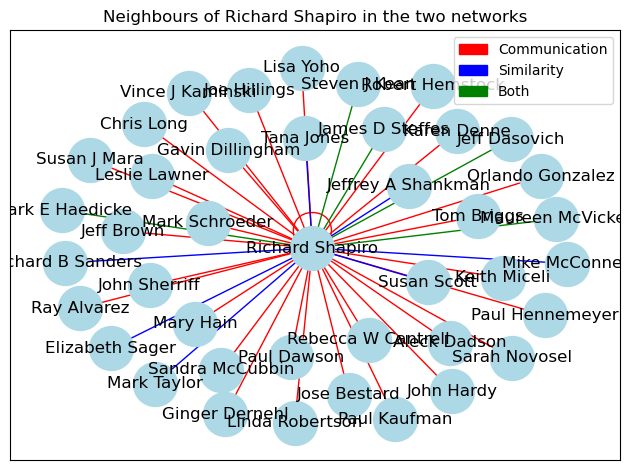

In [18]:
visualise_sender_networks(G_comm, G_sim_1, 'Richard Shapiro')

### Permutation test

In [64]:
def keep_common_nodes(G1, G2):
    G1_trunc = G1.subgraph(G2.nodes)
    G2_trunc = G2.subgraph(G1.nodes)
    return G1_trunc, G2_trunc

In [35]:
def calculate_intersection_dict(G_comm, G_sim):
    # Iterate over all nodes and find the neighbors of each node in G_comm and G_sim
    intersection_dict = {}
    for node in G_comm.nodes:
        # Check if node is in both graphs
        if node not in G_sim.nodes:
            print(f"Node '{node}' is not in both graphs")
            continue
        network_comm_neighbors = set(G_comm.neighbors(node))
        network_sim_neighbors = set(G_sim.neighbors(node))
        intersection = network_comm_neighbors.intersection(network_sim_neighbors)
        union = network_comm_neighbors.union(network_sim_neighbors)
        jaccard_similarity = len(intersection) / len(union)
        intersection_dict[node] = {
            'intersection': intersection,
            'union': union,
            'jaccard_similarity': jaccard_similarity
        }
    return intersection_dict

In [36]:
def run_permutation_test(G_comm, G_sim):

    # Keep only the common nodes and calculate the intersection dictionary
    G_comm, G_sim = keep_common_nodes(G_comm, G_sim)
    common_nodes = list(G_comm.nodes)
    intersection_dict = calculate_intersection_dict(G_comm, G_sim)

    # Define population for permutation test
    comm_population = []
    for node in common_nodes:
        comm_neighbors = set(G_comm.neighbors(node))
        comm_population.append(list(comm_neighbors))

    sim_population = []
    for node in common_nodes:
        sim_neighbors = set(G_sim.neighbors(node))
        sim_population.append(list(sim_neighbors))

    # Perform the permutation test by examining random pairs of communication and similarity networks
    num_permutations = min(len(common_nodes), 20)
    p_values = []
    permuted_jaccard_values = []
    observed_jaccard_values = []

    for i in range(num_permutations):

        # Choose a network of communication
        comm_network = set(comm_population[i])
        # Retrieve the Jaccard similarity calculated before for the specific network
        observed_jaccard_values.append(intersection_dict[common_nodes[i]]['jaccard_similarity'])
        # Remove the respective similarity network for the similarity population
        new_sim_population = sim_population[:i] + sim_population[i+1:]

        # Try different combinations with networks of similarity
        for _ in range(num_permutations):

            # Permute the networks of similarity
            random.shuffle(new_sim_population)
        
            for j in range(0, len(new_sim_population)):
                sim_network = set(new_sim_population[j])
                # Calculate the Jaccard similarity for the specific pair of networks
                intersection = comm_network.intersection(sim_network)
                union = comm_network.union(sim_network)
                jaccard_similarity = len(intersection) / len(union) if len(union) > 0 else 0
                permuted_jaccard_values.append(jaccard_similarity)
                # Check if the Jaccard similarity is greater than the observed one
                p_values.append(jaccard_similarity >= observed_jaccard_values[-1])

    # Calculate the p-value and the observed Jaccard similarity
    p_value = np.mean(p_values)
    observed_jaccard = np.mean(observed_jaccard_values)
    print(f"Observed Jaccard similarity = {observed_jaccard:.5f}")
    print(f"p-value = {p_value}")

    return p_value, observed_jaccard, permuted_jaccard_values

In [22]:
def visualise_permutation_test(permutation_jaccard_values, observed_jaccard):
    fig, ax = plt.subplots()
    ax.hist(permutation_jaccard_values, bins=30, edgecolor='black')
    ax.axvline(x=observed_jaccard, color='red', label='Observed value')
    ax.set_xlabel('Jaccard similarity')
    ax.set_ylabel('Frequency')
    ax.set_title('Permutation test for the Jaccard similarity')
    ax.legend()
    plt.show()

Observed Jaccard similarity = 0.41041
p-value = 0.146


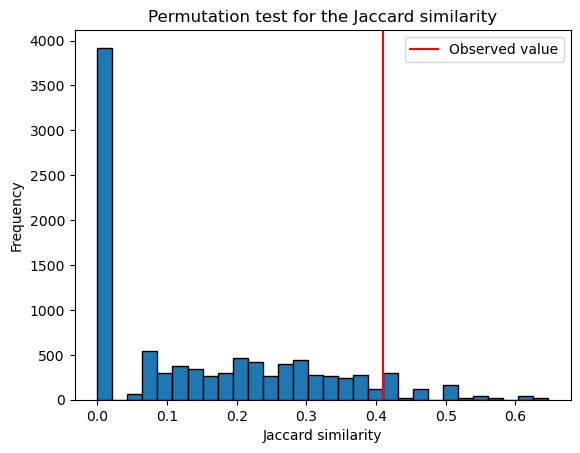

In [23]:
p_value, observed_jaccard, permutation_jaccard_values = run_permutation_test(G_comm, G_sim_1)
visualise_permutation_test(permutation_jaccard_values, observed_jaccard)

Observed Jaccard similarity = 0.33312
p-value = 0.23391812865497075


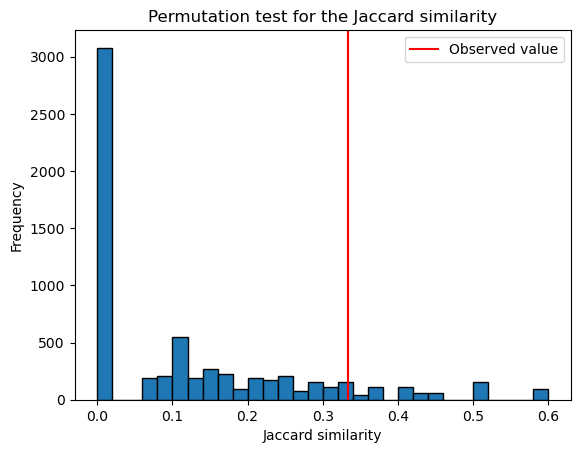

In [24]:
p_value, observed_jaccard, permutation_jaccard_values = run_permutation_test(G_comm, G_sim_2)
visualise_permutation_test(permutation_jaccard_values, observed_jaccard)

Observed Jaccard similarity = 0.42786
p-value = 0.1394736842105263


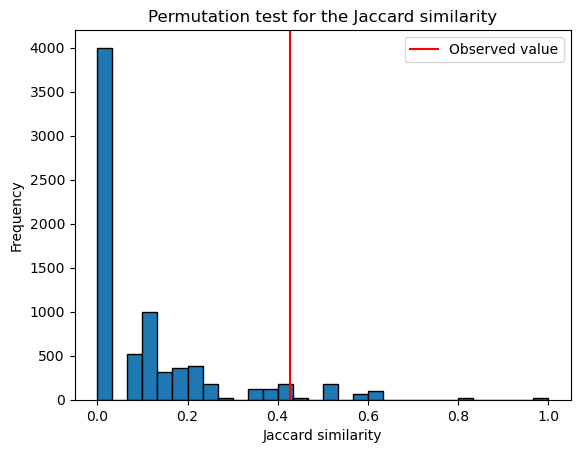

In [25]:
p_value, observed_jaccard, permutation_jaccard_values = run_permutation_test(G_comm, G_sim_3)
visualise_permutation_test(permutation_jaccard_values, observed_jaccard)

Observed Jaccard similarity = 0.48002
p-value = 0.14


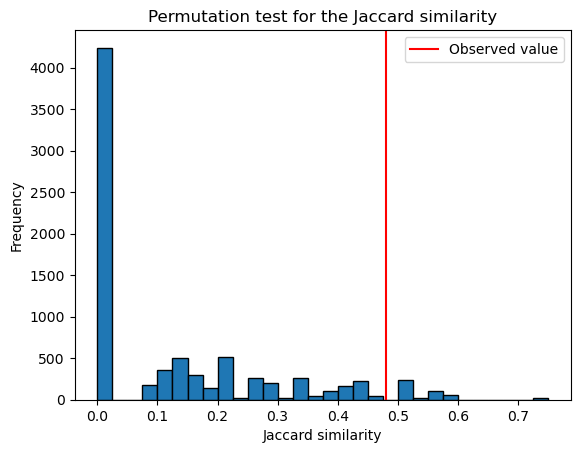

In [26]:
p_value, observed_jaccard, permutation_jaccard_values = run_permutation_test(G_comm, G_sim_4)
visualise_permutation_test(permutation_jaccard_values, observed_jaccard)

Observed Jaccard similarity = 0.39988
p-value = 0.18947368421052632


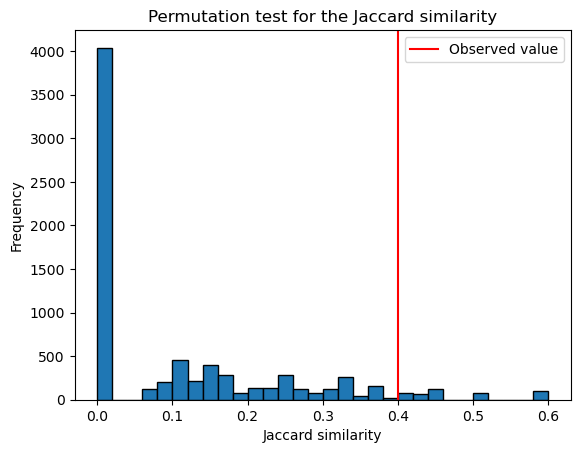

In [27]:
p_value, observed_jaccard, permutation_jaccard_values = run_permutation_test(G_comm, G_sim_5)
visualise_permutation_test(permutation_jaccard_values, observed_jaccard)

### Sentiment Analysis

In [32]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gkanellopoulos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gkanellopoulos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/gkanellopoulos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/gkanellopoulos/nltk_data...


True

In [29]:
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer

# Function to tokenize text, remove punctuation, stopwords, and find top 5 lemmas of frequency
def get_top_lemmas(text, n=5):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalnum()]
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    lemma_counts = Counter(lemmas)
    top_lemmas = lemma_counts.most_common(n)
    return top_lemmas

In [72]:
def calculate_pos_neg_sentiment(word_freq):
    sia = SentimentIntensityAnalyzer()
    # Analyze the sentiment of each word and classify as positive or negative
    positive_words = []
    negative_words = []
    for word, _ in word_freq:
        sentiment_scores = sia.polarity_scores(word)
        if sentiment_scores['compound'] >= 0.05:
            positive_words.append(word)
        elif sentiment_scores['compound'] <= -0.05:
            negative_words.append(word)

    # Calculate percentages
    total_count = sum(freq for _, freq in word_freq)
    positive_percentage = (len(positive_words) / total_count) * 100
    negative_percentage = (len(negative_words) / total_count) * 100
    return positive_percentage, negative_percentage

In [73]:
def get_sentiment_score(word_freq):
    sia = SentimentIntensityAnalyzer()
    lemma_scores = {lemma: sia.polarity_scores(lemma) for lemma, _ in word_freq}
    weighted_score = sum(lemma_scores[lemma]['compound'] * freq for lemma, freq in word_freq)
    normalized_score = weighted_score / sum(freq for _, freq in word_freq)
    return normalized_score

In [80]:
from scipy.stats import pearsonr

def correlate_jaccard_sentiment(G_comm, G_sim):
    # Keep only the common nodes and calculate the intersection dictionary
    G_comm, G_sim = keep_common_nodes(G_comm, G_sim)
    common_nodes = list(G_comm.nodes)
    intersection_dict = calculate_intersection_dict(G_comm, G_sim)

    # Calculate the sentiment score for each node in the intersection
    sentiment_scores = []
    positive_sentiments = []
    negative_sentiments = []
    for node in common_nodes:
        text = senderTextdf[senderTextdf['Sender'] == node]['All texts'].values[0]
        top_lemmas = get_top_lemmas(text, n=100)
        sentiment_score = get_sentiment_score(top_lemmas)
        sentiment_scores.append(sentiment_score)
        positive_sentiment, negative_sentiment = calculate_pos_neg_sentiment(top_lemmas)
        positive_sentiments.append(positive_sentiment)
        negative_sentiments.append(negative_sentiment)

    # Calculate the correlation between the Jaccard similarity and the sentiment score
    jaccard_values = [intersection_dict[node]['jaccard_similarity'] for node in common_nodes]
    correlation, _ = pearsonr(jaccard_values, sentiment_scores)
    print(f"Correlation between Jaccard similarity and sentiment score: {correlation:.5f}")
    correlation, _ = pearsonr(jaccard_values, positive_sentiments)
    print(f"Correlation between Jaccard similarity and positive sentiment: {correlation:.5f}")
    correlation, _ = pearsonr(jaccard_values, negative_sentiments)
    print(f"Correlation between Jaccard similarity and negative sentiment: {correlation:.5f}")

    return

In [81]:
correlate_jaccard_sentiment(G_comm, G_sim_1)

Correlation between Jaccard similarity and sentiment score: -0.03055
Correlation between Jaccard similarity and positive sentiment: 0.50558
Correlation between Jaccard similarity and negative sentiment: 0.10259


In [82]:
correlate_jaccard_sentiment(G_comm, G_sim_2)

Correlation between Jaccard similarity and sentiment score: -0.33696
Correlation between Jaccard similarity and positive sentiment: 0.21516
Correlation between Jaccard similarity and negative sentiment: 0.27169


In [83]:
correlate_jaccard_sentiment(G_comm, G_sim_3)

Correlation between Jaccard similarity and sentiment score: 0.04219
Correlation between Jaccard similarity and positive sentiment: 0.22043
Correlation between Jaccard similarity and negative sentiment: -0.26340


In [84]:

correlate_jaccard_sentiment(G_comm, G_sim_4)

Correlation between Jaccard similarity and sentiment score: 0.01657
Correlation between Jaccard similarity and positive sentiment: 0.27575
Correlation between Jaccard similarity and negative sentiment: -0.04276


In [85]:
correlate_jaccard_sentiment(G_comm, G_sim_5)

Correlation between Jaccard similarity and sentiment score: -0.16479
Correlation between Jaccard similarity and positive sentiment: 0.42011
Correlation between Jaccard similarity and negative sentiment: 0.05014


### Calculate semantic similarity

In [89]:
import nltk
import spacy

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import pandas as pd

nltk.download('wordnet')
nltk.download('omw-1.4')

# contains mutiple lingustic feature such synonyms
nlp = spacy.load("en_core_web_md")

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/gkanellopoulos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/gkanellopoulos/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [90]:
def calculate_semantic_similarity(node1_lemmas, node2_lemmas):
    # Calculate the semantic similarity between two nodes based on their lemmas
    node1_lemmas = [lemma for lemma, _ in node1_lemmas]
    node2_lemmas = [lemma for lemma, _ in node2_lemmas]
    node1 = nlp(" ".join(node1_lemmas))
    node2 = nlp(" ".join(node2_lemmas))
    similarity = cosine_similarity(node1.vector.reshape(1, -1), node2.vector.reshape(1, -1))[0][0]
    return similarity

In [100]:
def graph_semantic_similarity(G_comm, G_sim):
    # Keep only the common nodes and calculate the intersection dictionary
    G_comm, G_sim = keep_common_nodes(G_comm, G_sim)
    common_nodes = list(G_comm.nodes)
    intersection_dict = calculate_intersection_dict(G_comm, G_sim)

    # Calculate the semantic similarity for each pair of nodes
    semantic_similarities = []
    for node in common_nodes:
        text = senderTextdf[senderTextdf['Sender'] == node]['All texts'].values[0]
        top_lemmas = get_top_lemmas(text, n=100)
        for neighbor in intersection_dict[node]['intersection']:
            neighbor_text = senderTextdf[senderTextdf['Sender'] == neighbor]['All texts'].values[0]
            neighbor_top_lemmas = get_top_lemmas(neighbor_text, n=100)
            similarity = calculate_semantic_similarity(top_lemmas, neighbor_top_lemmas)
            semantic_similarities.append(similarity)

    # Calculate the average semantic similarity
    average_similarity = np.mean(semantic_similarities)
    print(f"Average semantic similarity: {average_similarity:.5f}")

    return

In [101]:
graph_semantic_similarity(G_comm, G_sim_1)

Average semantic similarity: 0.95116


In [102]:
graph_semantic_similarity(G_comm, G_sim_2)

Average semantic similarity: 0.95195


In [103]:
graph_semantic_similarity(G_comm, G_sim_3)

Average semantic similarity: 0.95907


In [104]:
graph_semantic_similarity(G_comm, G_sim_4)

Average semantic similarity: 0.95550


In [105]:
graph_semantic_similarity(G_comm, G_sim_5)

Average semantic similarity: 0.94965
